# 量子最適化アルゴリズムの紹介
本ノートブックではMAXCUT問題を例に量子最適化アルゴリズムを実際に実装してみます。

## MAXCUT問題
MAXCUT問題は、グラフ理論という数学の分野に属する問題の一つです。グラフは、点（頂点）とそれをつなぐ線（辺）で構成されます。MAXCUT問題では、このグラフを二つのグループに分けて、各グループの間をつなぐ線の数を最大化することを目指します。
MAXCUT問題は画像処理や通信網・交通網などのネットワーク計画、データ分析などに応用されます。


### グラフの準備:
まず、グラフを用意します。コンピューターでは[networkx](https://networkx.org/documentation/stable/tutorial.html)というライブラリを用いてグラフを表現します。ここでは、以下のようなグラフを考えます。
下のグラフは頂点数4のグラフで、辺の数は4本です。

Google Colab で行う場合は、次のセルの「#」を削除して実行します。

In [ ]:
#!pip install qiskit qiskit-ibm-runtime qiskit-aer qiskit[visualization]
#!pip install qiskit-algorithms python-sat

qBraid で行う場合は、右上の「Python 3[Default]」をクリックして「Python 3[QDC24]」を選択し、次のセルの「#」を削除して実行したあと、上部の「Kernel」→「Restart Kernel...」からカーネルをリスタートしてください。

In [ ]:
#!pip install qiskit-algorithms pylatexenc python-sat networkx
#!sudo apt install graphviz --yes

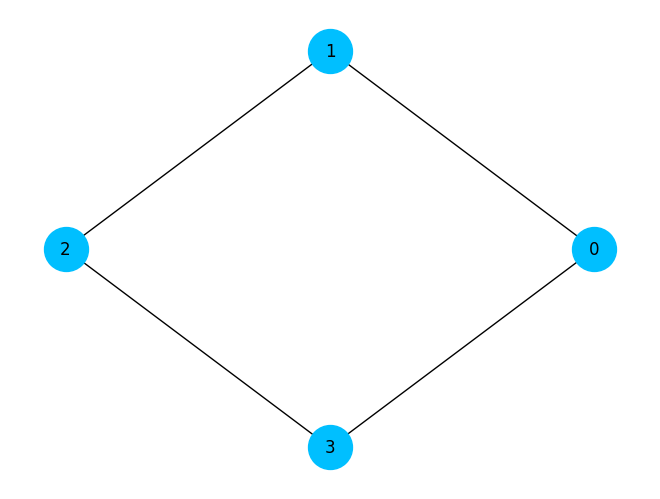

In [2]:
import networkx as nx

seed = 100
graph = nx.cycle_graph(4)
nx.draw(
    graph,
    with_labels=True,
    node_size=1000,
    node_color="deepskyblue",
    pos=nx.circular_layout(graph),
)

## グラフの分割:
このグラフを二つのグループに分けて、各グループの間をつなぐ線の数を最大化することを考えます。以下のように、グループ1に属する頂点を赤、グループ2に属する頂点を青で塗り分けることを考えます。

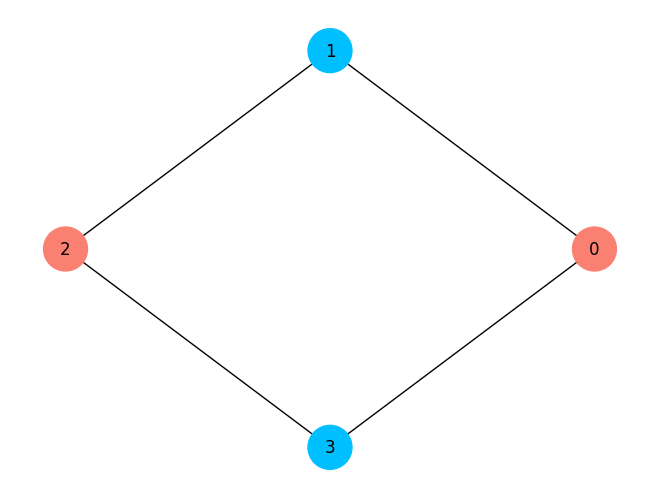

In [3]:
nx.draw(
    graph,
    with_labels=True,
    node_size=1000,
    pos=nx.circular_layout(graph),
    node_color=["salmon", "deepskyblue", "salmon", "deepskyblue"],
)

そうすると、グループ1とグループ2の間をつなぐ線の数は、4本になります。

## 量子コンピューターを使って解いてみよう
こんどは量子コンピューターを使ってMAXCUT問題を解いてみましょう。

### 事前準備
以下のセルを実行して、必要な関数を作成します。以下については、詳しく説明しませんが、量子コンピューターを使って最適化問題を解くための基本的な関数が定義されています。
本授業の本筋とは関係ないので分からなくても問題ありません。

`build_max_cut_paulis`は、MAXCUT問題を解くためのハミルトニアンを作成します。

In [4]:
"""
分からなくて大丈夫です
"""


def build_max_cut_paulis(graph: nx.Graph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in graph.edges():
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1]).get("weight", 1.0)

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

`evaluate_sparse_pauli`は、得られたビット列とハミルトニアンを使って、得られたビット列の目的関数の値を計算します。

`cost_func_sampler`は、Samplerを使って量子計算を行い、`evaluate_sparse_pauli`を使って目的関数の全体の値を計算します。

In [5]:
"""
分からなくて大丈夫です
"""

import numpy as np
from qiskit.quantum_info import SparsePauliOp


_PARITY = np.array(
    [-1 if bin(i).count("1") % 2 else 1 for i in range(256)], dtype=np.complex128
)


def evaluate_sparse_pauli(state: int, observable: SparsePauliOp) -> complex:
    """Utility for the evaluation of the expectation value of a measured state."""
    packed_uint8 = np.packbits(observable.paulis.z, axis=1, bitorder="little")
    state_bytes = np.frombuffer(
        state.to_bytes(packed_uint8.shape[1], "little"), dtype=np.uint8
    )
    reduced = np.bitwise_xor.reduce(packed_uint8 & state_bytes, axis=1)
    return np.sum(observable.coeffs * _PARITY[reduced])


def cost_func_sampler(params, ansatz, hamiltonian, sampler):
    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.meas.get_int_counts()
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {
        key: val / shots for key, val in sampled_int_counts.items()
    }

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, np.real(evaluate_sparse_pauli(state, hamiltonian)))
        for state, probability in int_count_distribution.items()
    }

    result = sum(probability * value for probability, value in evaluated.values())

    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict["params"] = params.tolist()
    temp_dict["fval"] = result
    temp_dict["distribution"] = sampled_int_counts
    temp_dict["evaluated"] = evaluated
    result_dict[iter_counts] = temp_dict
    print(f"Iteration {iter_counts}: {result}")

    return result

まず、問題をハミルトニアンの形へ変換します。

### 演習:　下記の`build_max_cut_paulis`関数にグラフを渡して、ハミルトニアンを作成してみましょう

In [6]:
max_cut_hamiltonian = build_max_cut_paulis(### ここに入力してください ###)
print(max_cut_hamiltonian)

[('IIZZ', 1.0), ('ZIIZ', 1.0), ('IZZI', 1.0), ('ZZII', 1.0)]


次に、変換したハミルトニアンからパラメーター付き量子回路を作成します。今回はQiskitの`QAOAAnsatz`を使用してハミルトニアンから自動でQAOAのAnsatzを作成します。

### 演習: 下記の`QAOAAnsatz`関数にハミルトニアンを渡して、QAOAのAnsatzを作成してみましょう

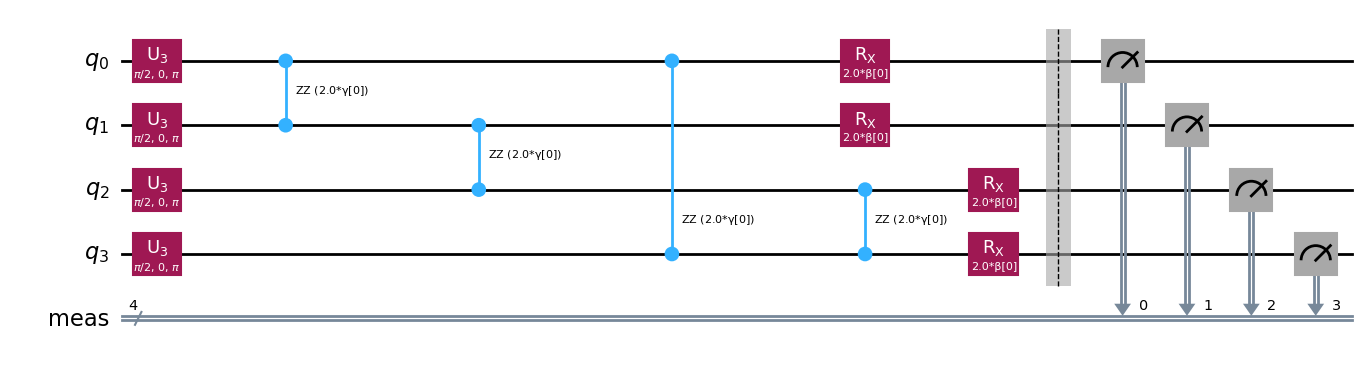

In [7]:
from qiskit.circuit.library import QAOAAnsatz


# QAOAAnsatzにわたすために形式を変換します
cost_hamiltonian = SparsePauliOp.from_list(max_cut_hamiltonian)

ansatz = QAOAAnsatz(
    ### ここに入力してください ###,
    reps=1,
).decompose()
ansatz.measure_all()
ansatz.decompose(reps=2).draw(output="mpl", fold=False)

量子ビットがそれぞれの頂点に対応しており、量子ビットの状態が0か1かで、その頂点がどちらのグループに属するかを表します。
青い２量子ビットゲートがそれぞれの辺に対応しています。

今回はシミューレーターを使って計算を行います。計算には２，３分くらいかかります。


下記セルでは計算のための準備として、シミュレーターを用意しています。

In [8]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService

# 初めて実行する場合、またはGoogle Colab で行う場合は、次の「#」を削除して、https://quantum.ibm.com/ の API Tokenをコピペして、実行します。
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='<IBM Quantum API key>')

service = QiskitRuntimeService()
fake_backend = FakeSherbrooke()

pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)
isa_qc = pm.run(ansatz)

# You can use a fixed seed to get fixed results.
options = {"simulator": {"seed_simulator": 42}}
sampler = Sampler(mode=fake_backend, options=options)

`minimize`関数に上で準備した`cost_func_sampler`関数と量子回路、ハミルトニアンを渡します。パラメーターを変えながら繰り返し実行し、最適化を行います。


### 演習: 下記の`minimize`関数に`cost_func_sampler`関数を渡して、最適化を行ってみましょう

In [10]:
from scipy.optimize import minimize

initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_gamma, initial_beta]

iter_counts = 0
result_dict = {}

result = minimize(
    ### ここに入力してください ###,
    init_params,
    args=(isa_qc, cost_hamiltonian, sampler),
    method="COBYLA",
    tol=1e-2,
)
print(result)

Iteration 1: -0.12890625
Iteration 2: -0.1328125
Iteration 3: 0.921875
Iteration 4: -1.109375
Iteration 5: 1.34765625
Iteration 6: -0.50390625
Iteration 7: -1.41015625
Iteration 8: -0.26171875
Iteration 9: -1.49609375
Iteration 10: -0.87890625
Iteration 11: -1.70703125
Iteration 12: -1.89453125
Iteration 13: -1.56640625
Iteration 14: -1.89453125
Iteration 15: -1.84765625
Iteration 16: -1.8828125
Iteration 17: -1.8984375
Iteration 18: -1.8828125
Iteration 19: -1.89453125
Iteration 20: -1.8984375
Iteration 21: -1.875
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.875
       x: [ 4.297e+00  3.784e-01]
    nfev: 21
   maxcv: 0.0


実験結果を表示してみましょう

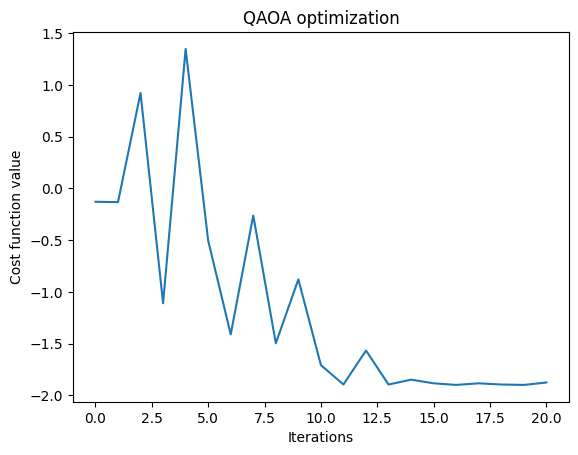

In [11]:
import matplotlib.pyplot as plt

plt.plot([result_dict[i]["fval"] for i in result_dict])
plt.xlabel("Iterations")
plt.ylabel("Cost function value")
plt.title("QAOA optimization")
plt.show()

目的関数の値が段々と小さくなっていっていることが分かります。

`calc_edges`関数を用いて、最終的な解を表示してみましょう。

In [13]:
sorted_evaluated = sorted(
    result_dict[iter_counts]["evaluated"].items(), key=lambda x: x[1][1]
)

# convert the state to binary
state = sorted_evaluated[0][0]
state_bin = format(state, "010b")

def calc_edges(state_bin, cost_operator):
    edges = []
    for pauli in cost_operator.paulis:
        temp = []
        for i, p in enumerate(pauli):
            if str(p) == "Z":
                temp.append(i)
        if state_bin[temp[0]] != state_bin[temp[1]]:
            edges.append(temp)
    return edges


edges = calc_edges(state_bin[::-1], cost_hamiltonian)
print(len(edges), edges)

4 [[0, 1], [0, 3], [1, 2], [2, 3]]


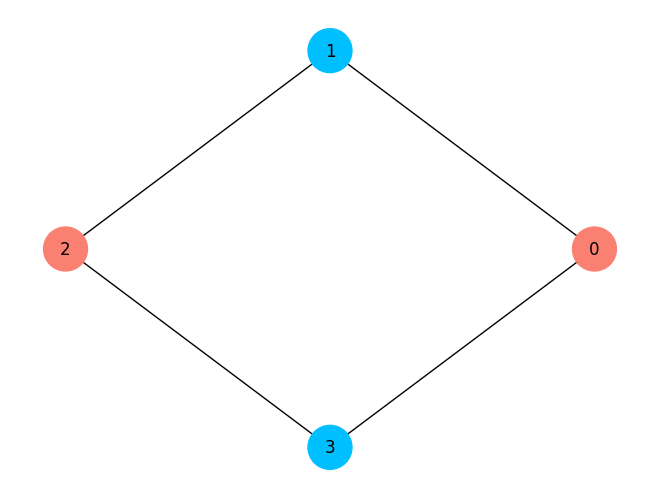

In [14]:
node_color = [
    "salmon" if int(state_bin[::-1][node]) else "deepskyblue" for node in graph.nodes
]
nx.draw(
    graph,
    with_labels=True,
    node_size=1000,
    node_color=node_color,
    pos=nx.circular_layout(graph),
)

グループの分け方は少し違いますが、グループ間をつなぐ辺の数を最大化することができました。

## 100量子ビットを使って実験してみよう！

127量子ビットデバイスを使って、100量子ビットのMAXCUT問題を解いてみましょう。まずデバイスを用意します。

In [15]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_cusco')>


実際のデバイスでは量子ビットが下図のように結合されていて、全ての量子ビットがお互いにつながっているわけではありません。今回は実際のデバイスの量子ビットの結合関係を考慮して下図の１００ノードのグラフを作成します。

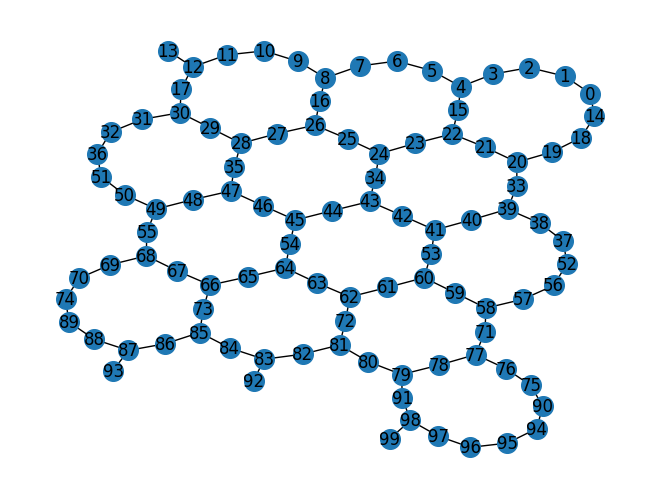

In [16]:
n = 100  # Number of nodes in graph
graph_100 = nx.Graph()
graph_100.add_nodes_from(np.arange(0, n, 1))
elist = []
for edge in backend.coupling_map:
    if edge[0] < n and edge[1] < n:
        elist.append((edge[0], edge[1]))
graph_100.add_edges_from(elist)
nx.draw(
    graph_100,
    node_size=200,
    with_labels=True,
    width=1,
    pos=nx.kamada_kawai_layout(graph_100),
)

今回は上記グラフのMAXCUT問題を解いてみましょう。

さきほどの小さいサイズの問題の場合と同じように、まず`build_max_cut_paulis`関数にグラフを渡して、ハミルトニアンを作成します。

In [17]:
max_cut_paulis_100 = build_max_cut_paulis(graph_100)

cost_hamiltonian_100 = SparsePauliOp.from_list(max_cut_paulis_100)
print("Cost Function Hamiltonian:", cost_hamiltonian_100)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIII', 'IIIIIIIIIIIIIIIIIIIII

`QAOAAnsatz`関数にハミルトニアンを渡して、QAOAのAnsatzを作成します。

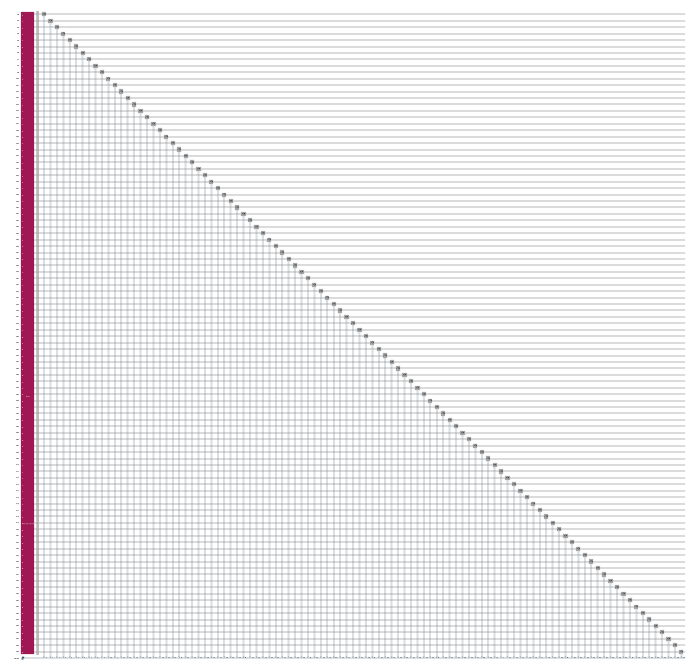

In [18]:
circuit_100 = QAOAAnsatz(cost_operator=cost_hamiltonian_100, reps=2)
circuit_100.measure_all()

circuit_100.draw("mpl", fold=False, scale=0.1, idle_wires=False)

作成した量子回路を表示してみましょう。

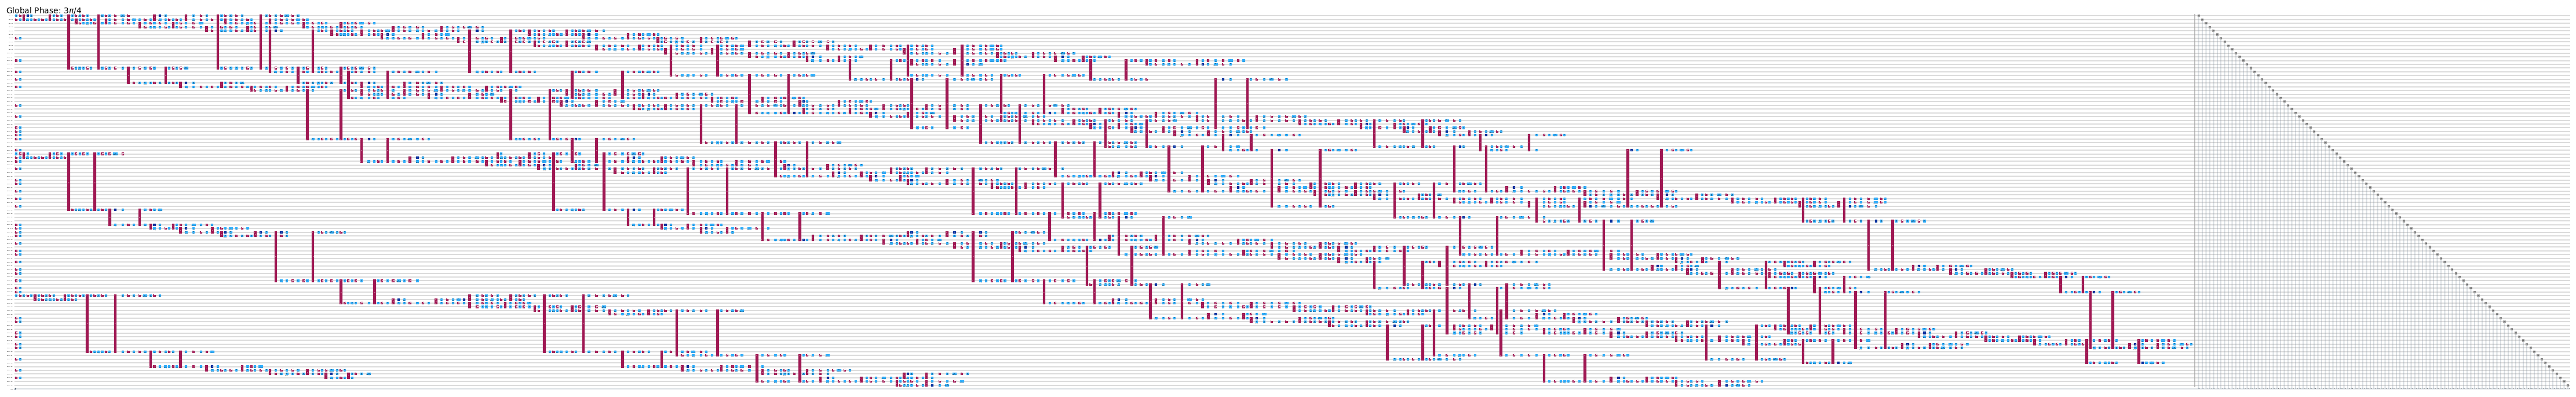

In [19]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit_100 = pm.run(circuit_100)
candidate_circuit_100.draw("mpl", fold=False, scale=0.1, idle_wires=False)

大きなサイズの量子回路になっています。

## 量子回路の最適化
実は最適化問題で使用している量子回路そのものも最適化することができます。それにより、量子回路の深さや全体のゲートの個数を減らすことが可能です。
今回は、最適化問題を解くための量子回路を最適化する方法を少し紹介します。パワーポイントの付録を参照してください。

### 事前準備
以下のセルを実行して、必要な関数を作成します。以下については、本授業の範囲外になるので詳しく説明しませんが、量子回路の最適化に必要な関数が定義されています。以下のプログラムが分からなくても問題ありません。

今回の量子回路の最適化ではSwap strategy[1]とSAT initial mapping[2]と呼ばれる手法を使います。

[1] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870.

[2] Matsuo, A., Yamashita, S., & Egger, D. J. (2023). A SAT approach to the initial mapping problem in SWAP gate insertion for commuting gates. IEICE Transactions on Fundamentals of Electronics, Communications and Computer Sciences, 106(11), 1424-1431.

量子ビットの結合関係をもとに、Swap strategyを準備します。

In [21]:
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy


swap_strategy = SwapStrategy(CouplingMap(list(graph_100.edges())), ((())))

SAT initial mappingに必要な関数を準備します。

In [22]:
"""A class to solve the SWAP gate insertion initial mapping problem
using the SAT approach from https://arxiv.org/abs/2212.05666.
"""

from __future__ import annotations

from dataclasses import dataclass
from itertools import combinations
from threading import Timer

import numpy as np

from pysat.formula import CNF, IDPool
from pysat.solvers import Solver


@dataclass
class SATResult:
    """A data class to hold the result of a SAT solver."""

    satisfiable: (
        bool  # Satisfiable is True if the SAT model could be solved in a given time.
    )
    solution: dict  # The solution to the SAT problem if it is satisfiable.
    mapping: (
        list  # The mapping of nodes in the pattern graph to nodes in the target graph.
    )
    elapsed_time: float  # The time it took to solve the SAT model.


class SATMapper:
    r"""A class to introduce a SAT-approach to solve
    the initial mapping problem in SWAP gate insertion for commuting gates.

    When this pass is run on a DAG it will look for the first instance of
    :class:`.Commuting2qBlock` and use the program graph :math:`P` of this block of gates to
    find a layout for a given swap strategy. This layout is found with a
    binary search over the layers :math:`l` of the swap strategy. At each considered layer
    a subgraph isomorphism problem formulated as a SAT is solved by a SAT solver. Each instance
    is whether it is possible to embed the program graph :math:`P` into the effective
    connectivity graph :math:`C_l` that is achieved by applying :math:`l` layers of the
    swap strategy to the coupling map :math:`C_0` of the backend. Since solving SAT problems
    can be hard, a ``time_out`` fixes the maximum time allotted to the SAT solver for each
    instance. If this time is exceeded the considered problem is deemed unsatisfiable and
    the binary search proceeds to the next number of swap layers :math:``l``.
    """

    def __init__(self, timeout: int = 60):
        """Initialize the SATMapping.

        Args:
            timeout: The allowed time in seconds for each iteration of the SAT solver. This
                variable defaults to 60 seconds.
        """
        self.timeout = timeout

    def find_initial_mappings(
        self,
        program_graph: nx.Graph,
        swap_strategy: SwapStrategy,
        min_layers: int | None = None,
        max_layers: int | None = None,
    ) -> dict[int, SATResult]:
        r"""Find an initial mapping for a given swap strategy. Perform a binary search
        over the number of swap layers, and for each number of swap layers solve a
        subgraph isomorphism problem formulated as a SAT problem.

        Args:
            program_graph (nx.Graph): The program graph with commuting gates, where
                                        each edge represents a two-qubit gate.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.
            min_layers (int): The minimum number of swap layers to consider. Defaults to
            the maximum degree of the program graph - 2.
            max_layers (int): The maximum number of swap layers to consider. Defaults to
            the number of qubits in the swap strategy - 2.

        Returns:
            dict[int, SATResult]: A dictionary containing the results of the SAT solver for
                                    each number of swap layers.
        """
        # pylint: disable=too-many-locals
        num_nodes_g1 = len(program_graph.nodes)
        num_nodes_g2 = swap_strategy.distance_matrix.shape[0]
        if num_nodes_g1 > num_nodes_g2:
            return SATResult(False, [], [], 0)
        if min_layers is None:
            # use the maximum degree of the program graph - 2 as the lower bound.
            min_layers = max((d for _, d in program_graph.degree)) - 2
        if max_layers is None:
            max_layers = num_nodes_g2 - 1

        variable_pool = IDPool(start_from=1)
        variables = np.array(
            [
                [variable_pool.id(f"v_{i}_{j}") for j in range(num_nodes_g2)]
                for i in range(num_nodes_g1)
            ],
            dtype=int,
        )
        vid2mapping = {v: idx for idx, v in np.ndenumerate(variables)}
        binary_search_results = {}

        def interrupt(solver):
            # This function is called to interrupt the solver when the timeout is reached.
            solver.interrupt()

        # Make a cnf for the one-to-one mapping constraint
        cnf1 = []
        for i in range(num_nodes_g1):
            clause = variables[i, :].tolist()
            cnf1.append(clause)
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])
        for j in range(num_nodes_g2):
            clause = variables[:, j].tolist()
            for k, m in combinations(clause, 2):
                cnf1.append([-1 * k, -1 * m])

        # Perform a binary search over the number of swap layers to find the minimum
        # number of swap layers that satisfies the subgraph isomorphism problem.
        while min_layers < max_layers:
            num_layers = (min_layers + max_layers) // 2

            # Create the connectivity matrix. Note that if the swap strategy cannot reach
            # full connectivity then its distance matrix will have entries with -1. These
            # entries must be treated as False.
            d_matrix = swap_strategy.distance_matrix
            connectivity_matrix = ((-1 < d_matrix) & (d_matrix <= num_layers)).astype(
                int
            )
            # Make a cnf for the adjacency constraint
            cnf2 = []
            for e_0, e_1 in program_graph.edges:
                clause_matrix = np.multiply(connectivity_matrix, variables[e_1, :])
                clause = np.concatenate(
                    (
                        [[-variables[e_0, i]] for i in range(num_nodes_g2)],
                        clause_matrix,
                    ),
                    axis=1,
                )
                # Remove 0s from each clause
                cnf2.extend([c[c != 0].tolist() for c in clause])

            cnf = CNF(from_clauses=cnf1 + cnf2)

            with Solver(bootstrap_with=cnf, use_timer=True) as solver:
                # Solve the SAT problem with a timeout.
                # Timer is used to interrupt the solver when the timeout is reached.
                timer = Timer(self.timeout, interrupt, [solver])
                timer.start()
                status = solver.solve_limited(expect_interrupt=True)
                timer.cancel()
                # Get the solution and the elapsed time.
                sol = solver.get_model()
                e_time = solver.time()

                if status:
                    # If the SAT problem is satisfiable, convert the solution to a mapping.
                    mapping = [vid2mapping[idx] for idx in sol if idx > 0]
                    binary_search_results[num_layers] = SATResult(
                        status, sol, mapping, e_time
                    )
                    max_layers = num_layers
                else:
                    # If the SAT problem is unsatisfiable, return the last satisfiable solution.
                    binary_search_results[num_layers] = SATResult(
                        status, sol, [], e_time
                    )
                    min_layers = num_layers + 1

        return binary_search_results

    def remap_graph_with_sat(
        self, graph: nx.Graph, swap_strategy
    ) -> tuple[int, dict, list] | tuple[None, None, None]:
        """Applies the SAT mapping.

        Args:
            graph (nx.Graph): The graph to remap.
            swap_strategy (SwapStrategy): The swap strategy to use to find the initial mapping.

        Returns:
            tuple: A tuple containing the remapped graph, the edge map, and the number of layers of
            the swap strategy that was used to find the initial mapping. If no solution is found
            then the tuple contains None for each element.
            Note the returned edge map `{k: v}` means that node `k` in the original
            graph gets mapped to node `v` in the Pauli strings.
        """
        num_nodes = len(graph.nodes)
        results = self.find_initial_mappings(graph, swap_strategy, 0, num_nodes - 1)
        solutions = [k for k, v in results.items() if v.satisfiable]
        if len(solutions):
            min_k = min(solutions)
            edge_map = dict(results[min_k].mapping)
            remapped_graph = nx.relabel_nodes(graph, edge_map)
            return remapped_graph, edge_map, min_k
        else:
            return None, None, None

SAT initial mappingを計算します。

In [23]:
sm = SATMapper(timeout=10)
remapped_graph, edge_map, min_swap_layers = sm.remap_graph_with_sat(
    graph=graph_100, swap_strategy=swap_strategy
)

計算結果をもとにハミルトニアンの要素を並び替えます。

In [25]:
remapped_max_cut_paulis = build_max_cut_paulis(remapped_graph)
remapped_cost_operator = SparsePauliOp.from_list(remapped_max_cut_paulis)

最適化した量子回路を作成するための関数を準備します。

In [26]:
"""
分からなくて大丈夫です
"""

from qiskit.circuit import QuantumCircuit
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector


def make_meas_map(circuit: QuantumCircuit) -> dict:
    """Return a mapping from qubit index (the key) to classical bit (the value).

    This allows us to account for the swapping order introduced by the SwapStrategy.
    """
    creg = circuit.cregs[0]
    qreg = circuit.qregs[0]

    meas_map = {}
    for inst in circuit.data:
        if inst.operation.name == "measure":
            meas_map[qreg.index(inst.qubits[0])] = creg.index(inst.clbits[0])

    return meas_map


def apply_swap_strategy(
    circuit: QuantumCircuit,
    swap_strategy: SwapStrategy,
    edge_coloring: dict[tuple[int, int], int] | None = None,
) -> QuantumCircuit:
    """Transpile with a SWAP strategy.

    Returns:
        A quantum circuit transpiled with the given swap strategy.
    """

    pm_pre = PassManager(
        [
            FindCommutingPauliEvolutions(),
            Commuting2qGateRouter(
                swap_strategy,
                edge_coloring,
            ),
        ]
    )
    return pm_pre.run(circuit)


def apply_qaoa_layers(  # pylint: disable=too-many-arguments,too-many-locals
    cost_layer: QuantumCircuit,
    meas_map: dict,
    num_layers: int,
    gamma: list[float] | ParameterVector = None,
    beta: list[float] | ParameterVector = None,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Applies QAOA layers to construct circuit.

    First, the initial state is applied. If `initial_state` is None we begin in the
    initial superposition state. Next, we alternate between layers of the cot operator
    and the mixer. The cost operator is alternatively applied in order and in reverse
    instruction order. This allows us to apply the swap-strategy on odd `p` layers
    and undo the swap strategy on even `p` layers.
    """

    num_qubits = cost_layer.num_qubits
    new_circuit = QuantumCircuit(num_qubits, num_qubits)

    if initial_state is not None:
        new_circuit.append(initial_state, range(num_qubits))
    else:
        # all h state by default
        new_circuit.h(range(num_qubits))

    if gamma is None or beta is None:
        gamma = ParameterVector("γ", num_layers)
        if mixer is None or mixer.num_parameters == 0:
            beta = ParameterVector("β", num_layers)
        else:
            beta = ParameterVector("β", num_layers * mixer.num_parameters)

    if mixer is not None:
        mixer_layer = mixer
    else:
        mixer_layer = QuantumCircuit(num_qubits)
        mixer_layer.rx(-2 * beta[0], range(num_qubits))

    for layer in range(num_layers):
        bind_dict = {cost_layer.parameters[0]: gamma[layer]}
        cost_layer_ = cost_layer.assign_parameters(bind_dict)
        bind_dict = {
            mixer_layer.parameters[i]: beta[layer + i]
            for i in range(mixer_layer.num_parameters)
        }
        layer_mixer = mixer_layer.assign_parameters(bind_dict)

        if layer % 2 == 0:
            new_circuit.append(cost_layer_, range(num_qubits))
        else:
            new_circuit.append(cost_layer_.reverse_ops(), range(num_qubits))

        new_circuit.append(layer_mixer, range(num_qubits))

    for qidx, cidx in meas_map.items():
        new_circuit.measure(qidx, cidx)

    return new_circuit


def create_qaoa_swap_circuit(  # pylint: disable=too-many-arguments
    cost_operator: SparsePauliOp,
    swap_strategy: SwapStrategy,
    edge_coloring: dict = None,
    theta: list[float] = None,
    qaoa_layers: int = 1,
    initial_state: QuantumCircuit = None,
    mixer: QuantumCircuit = None,
):
    """Create the circuit for QAOA.

    Notes: This circuit construction for QAOA works for quadratic terms in `Z` and will be
    extended to first-order terms in `Z`. Higher-orders are not supported.

    Args:
        cost_operator: the cost operator.
        swap_strategy: selected swap strategy
        edge_coloring: A coloring of edges that should correspond to the coupling
            map of the hardware. It defines the order in which we apply the Rzz
            gates. This allows us to choose an ordering such that `Rzz` gates will
            immediately precede SWAP gates to leverage CNOT cancellation.
        theta: The QAOA angles.
        qaoa_layers: The number of layers of the cost-operator and the mixer operator.
        initial_state: The initial state on which we apply layers of cost-operator
            and mixer.
        mixer: The QAOA mixer. It will be applied as is onto the QAOA circuit. Therefore,
            its output must have the same ordering of qubits as its input.
    """

    num_qubits = cost_operator.num_qubits

    if theta is not None:
        gamma = theta[: len(theta) // 2]
        beta = theta[len(theta) // 2 :]
        qaoa_layers = len(theta) // 2
    else:
        gamma = beta = None

    # First, create the ansatz of 1 layer of QAOA without mixer
    cost_layer = QAOAAnsatz(
        cost_operator,
        reps=1,
        initial_state=QuantumCircuit(num_qubits),
        mixer_operator=QuantumCircuit(num_qubits),
    ).decompose()

    # This will allow us to recover the permutation of the measurements that the swap introduce.
    cost_layer.measure_all()

    # Now, apply the swap strategy for commuting pauli evolution gates
    cost_layer = apply_swap_strategy(cost_layer, swap_strategy, edge_coloring)

    # Compute the measurement map (qubit to classical bit).
    # we will apply this for qaoa_layers % 2 == 1.
    if qaoa_layers % 2 == 1:
        meas_map = make_meas_map(cost_layer)
    else:
        meas_map = {idx: idx for idx in range(num_qubits)}

    cost_layer.remove_final_measurements()

    # Finally, introduce the mixer circuit and add measurements following measurement map
    circuit = apply_qaoa_layers(
        cost_layer, meas_map, qaoa_layers, gamma, beta, initial_state, mixer
    )

    return circuit

量子ゲートの入れ替えを行う方法を指定しています。
0, 1, 2がそれぞれのレイヤーに対応しています。

In [27]:
### 分からなくて大丈夫です ###
edge_coloring = {
    (0, 1): 0,
    (0, 14): 1,
    (1, 2): 1,
    (2, 3): 2,
    (4, 3): 0,
    (4, 15): 1,
    (5, 4): 2,
    (6, 5): 0,
    (7, 6): 1,
    (7, 8): 0,
    (8, 9): 1,
    (10, 9): 0,
    (10, 11): 1,
    (11, 12): 0,
    (13, 12): 2,
    (14, 18): 0,
    (16, 8): 2,
    (17, 12): 1,
    (17, 30): 0,
    (19, 18): 1,
    (20, 19): 0,
    (21, 20): 1,
    (21, 22): 0,
    (22, 15): 2,
    (22, 23): 1,
    (23, 24): 0,
    (24, 25): 1,
    (26, 16): 0,
    (26, 25): 2,
    (26, 27): 1,
    (28, 27): 0,
    (29, 28): 1,
    (29, 30): 2,
    (31, 30): 1,
    (31, 32): 0,
    (33, 20): 2,
    (33, 39): 0,
    (34, 24): 2,
    (35, 28): 2,
    (35, 47): 0,
    (36, 32): 1,
    (36, 51): 0,
    (37, 38): 0,
    (37, 52): 1,
    (39, 38): 1,
    (40, 39): 2,
    (40, 41): 0,
    (42, 41): 1,
    (42, 43): 0,
    (43, 34): 1,
    (44, 43): 2,
    (45, 44): 0,
    (45, 46): 1,
    (46, 47): 2,
    (48, 47): 1,
    (48, 49): 0,
    (50, 49): 1,
    (50, 51): 2,
    (53, 41): 2,
    (53, 60): 0,
    (54, 45): 2,
    (54, 64): 0,
    (55, 49): 2,
    (56, 52): 0,
    (57, 56): 1,
    (57, 58): 0,
    (58, 59): 1,
    (58, 71): 2,
    (59, 60): 2,
    (60, 61): 1,
    (61, 62): 0,
    (63, 62): 1,
    (63, 64): 2,
    (64, 65): 1,
    (66, 65): 0,
    (66, 67): 1,
    (67, 68): 0,
    (68, 55): 1,
    (68, 69): 2,
    (69, 70): 0,
    (70, 74): 1,
    (72, 62): 2,
    (72, 81): 0,
    (73, 66): 2,
    (73, 85): 0,
    (75, 76): 1,
    (75, 90): 0,
    (76, 77): 0,
    (77, 71): 1,
    (77, 78): 2,
    (79, 78): 0,
    (80, 79): 1,
    (80, 81): 2,
    (82, 81): 1,
    (82, 83): 0,
    (84, 83): 1,
    (85, 84): 2,
    (85, 86): 1,
    (87, 86): 0,
    (87, 93): 2,
    (88, 87): 1,
    (88, 89): 0,
    (89, 74): 2,
    (91, 79): 2,
    (91, 98): 0,
    (92, 83): 2,
    (94, 90): 1,
    (94, 95): 0,
    (96, 95): 1,
    (96, 97): 0,
    (97, 98): 1,
    (98, 99): 2,
}

In [28]:
# edge_coloring. If the second element is smalller than first element, swap them.
edge_coloring = {tuple(sorted(k)): v for k, v in edge_coloring.items()}

### 最適化した量子回路の作成

In [29]:
qaoa_circ = create_qaoa_swap_circuit(
    remapped_cost_operator, swap_strategy, edge_coloring=edge_coloring, qaoa_layers=1
)

最適化なしの量子回路

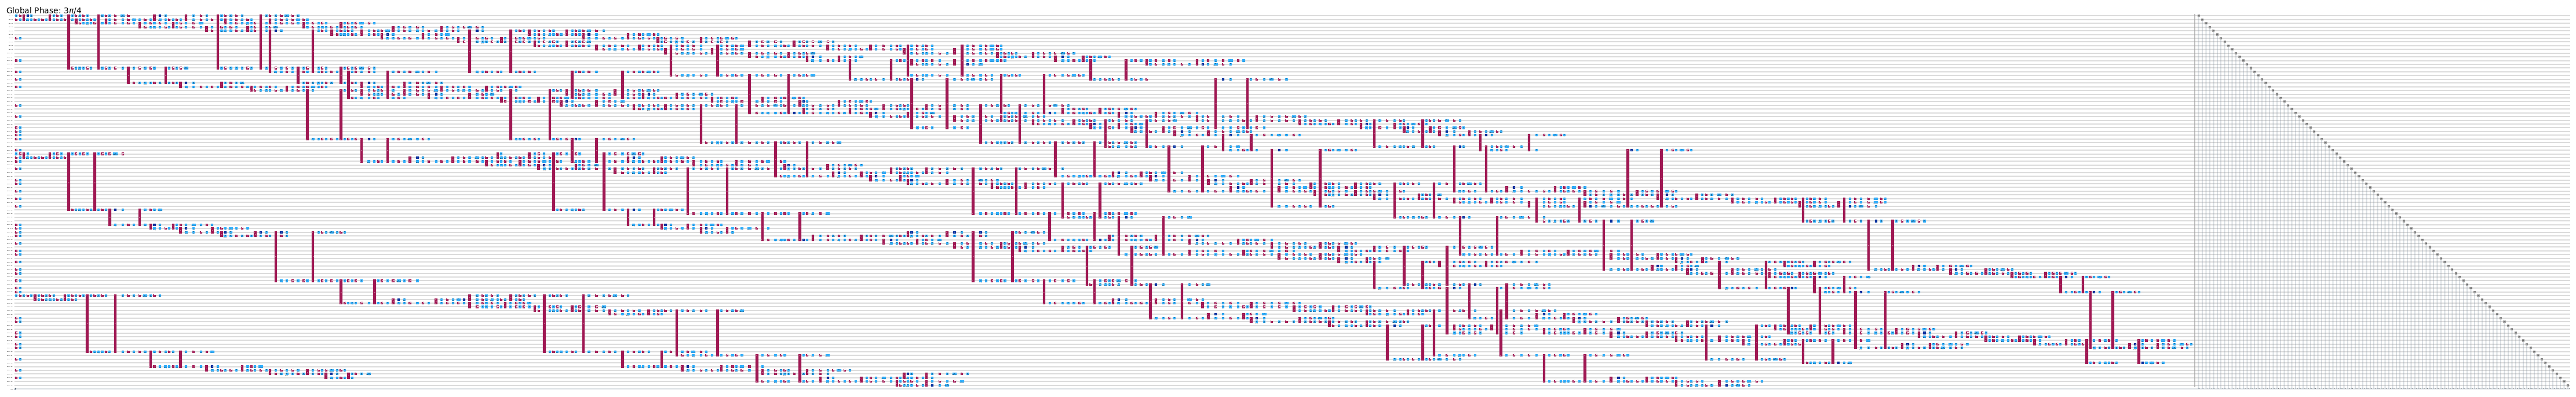

In [30]:
candidate_circuit_100.draw("mpl", fold=False, scale=0.1, idle_wires=False)

最適化ありの量子回路

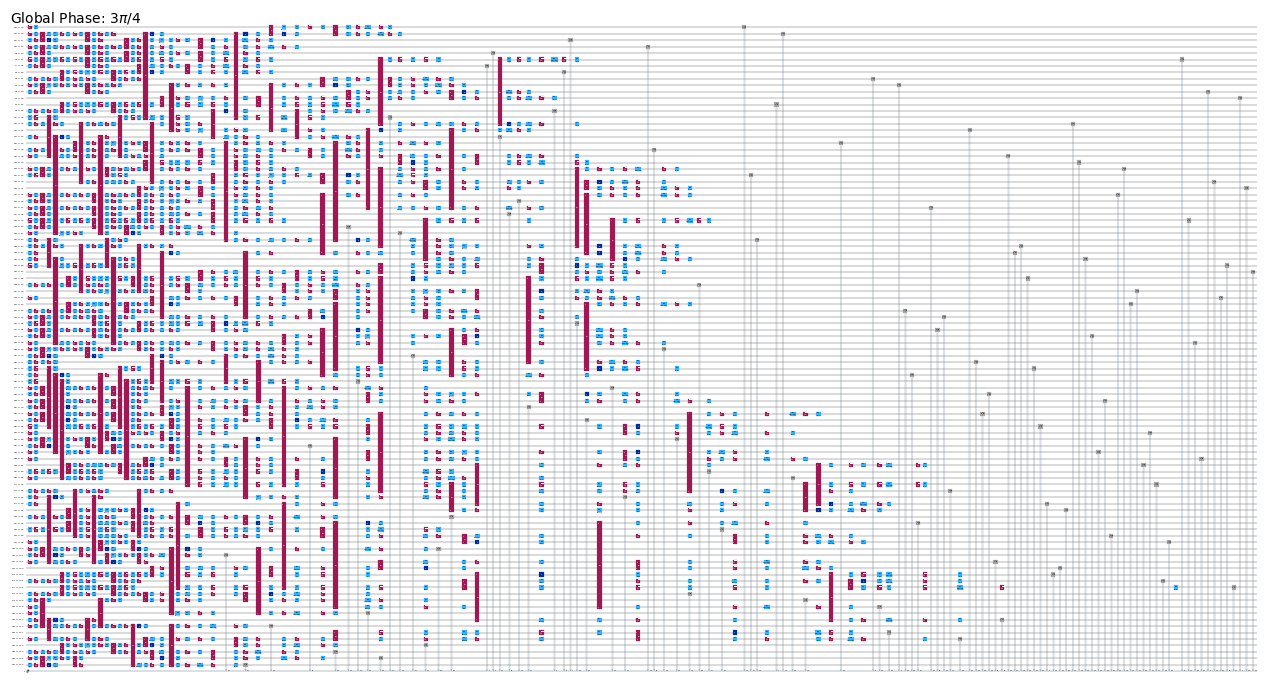

In [31]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

transpiled_qaoa_circ = pm.run(qaoa_circ)
transpiled_qaoa_circ.draw("mpl", fold=False, scale=0.1, idle_wires=False)

In [32]:
print("量子回路の深さ")
print("最適化なし", candidate_circuit_100.depth())
print("最適化あり", transpiled_qaoa_circ.depth())

量子回路の深さ
最適化なし 400
最適化あり 49


回路がの深さが最適化前と比べるとだいぶ小さくなりましたね。

## 実機での実験

今回は事前に計算したパラメーターを用いて量子回路を実行してみます。実行には時間がかかるのでjob_idを取得して、後で結果を確認します。

In [35]:
from qiskit_ibm_runtime import Session


# 事前に計算したパラメーター
init_params = [4.303, 2.765]


sampler = Sampler(mode=backend)
# Set error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"
sampler.options.twirling.enable_measure = True


job = sampler.run([(transpiled_qaoa_circ, init_params)])
job_id = job.job_id()
print(job_id)


ctmy2yb6g3rg0087c0vg


job_idを使って実験結果を取得します。

In [40]:
service = QiskitRuntimeService()
job = service.job(job_id)
print(job.status())

DONE


実機にはエラーがあったり、確率的なばらつきがあるので、このノートブックと結果が違っていても問題ありません。

In [39]:
sampler_result = job.result()
sampled_int_counts = sampler_result[0].data.c.get_int_counts()
shots = sum(sampled_int_counts.values())
int_count_distribution = {
    key: val / shots for key, val in sampled_int_counts.items()
}
# a dictionary containing: {state: (measurement probability, value)}
evaluated = {
    state: (probability, np.real(evaluate_sparse_pauli(state, remapped_cost_operator)))
    for state, probability in int_count_distribution.items()
}

result = sum(probability * value for probability, value in evaluated.values())
print(result)

-39.314453125

In [40]:
sorted_evaluated = sorted(
    evaluated.items(), key=lambda x: x[1][1]
)
print(sorted_evaluated[0])
state = sorted_evaluated[0][0]
state_bin = format(state, "0100b")

(890878377427335241666023582378, (0.000244140625, -78.0))


In [42]:
edges = calc_edges(state_bin[::-1], remapped_cost_operator)
print(len(edges), edges)

95 [[0, 1], [0, 14], [1, 2], [2, 3], [3, 4], [4, 15], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [12, 17], [14, 18], [15, 22], [16, 26], [17, 30], [18, 19], [19, 20], [20, 21], [20, 33], [21, 22], [22, 23], [23, 24], [24, 34], [25, 26], [27, 28], [28, 29], [28, 35], [29, 30], [30, 31], [31, 32], [33, 39], [34, 43], [35, 47], [36, 51], [37, 38], [37, 52], [38, 39], [39, 40], [40, 41], [41, 42], [42, 43], [43, 44], [44, 45], [45, 46], [46, 47], [47, 48], [48, 49], [49, 55], [50, 51], [52, 56], [53, 60], [54, 64], [55, 68], [56, 57], [57, 58], [58, 59], [60, 61], [61, 62], [62, 63], [62, 72], [63, 64], [65, 66], [66, 67], [66, 73], [67, 68], [68, 69], [70, 74], [73, 85], [74, 89], [75, 76], [75, 90], [76, 77], [77, 78], [78, 79], [79, 80], [79, 91], [80, 81], [81, 82], [82, 83], [83, 84], [83, 92], [84, 85], [86, 87], [87, 88], [88, 89], [90, 94], [91, 98], [95, 96], [97, 98], [98, 99]]


In [45]:
#save the result
import json

with open("result.json", "w") as f:
    json.dump(result_dict, f, indent=4)


結果を表示してみましょう。

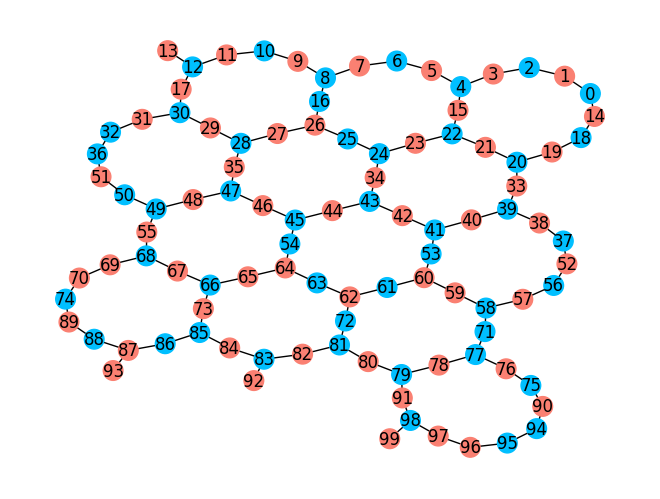

In [44]:
node_color = [
    "salmon" if int(state_bin[::-1][node]) else "deepskyblue" for node in remapped_graph.nodes
]
nx.draw(
    remapped_graph,
    with_labels=True,
    node_size=200,
    node_color=node_color,
    pos=nx.kamada_kawai_layout(remapped_graph),
)

## まとめ
今回は、QAOAという量子最適化のアルゴリズムを使ってMAXCUT問題を解いてみました。
実際の量子コンピューターを使って100量子ビットの計算をすることができました。

100量子ビットの計算は現在のスーパーコンピューターでもシミュレートすることは出来ず、量子コンピューターのみで実行することができます。
量子ユーティリティー時代では、今回学んだような量子最適化アルゴリズムを使って、様々な難しい問題を解いていくことが期待されます。

### 付録

100量子ビットの場合でも同様にQAOAの繰り返し実行を行い、最適なパラメーターを求めることができます。
長いと一晩くらいかかる可能性がありますが、時間がある人はやってみてください。

In [36]:
def cost_func_sampler(params, ansatz, hamiltonian, sampler):
    job = sampler.run([(ansatz, params)])
    sampler_result = job.result()
    sampled_int_counts = sampler_result[0].data.c.get_int_counts()
    shots = sum(sampled_int_counts.values())
    int_count_distribution = {
        key: val / shots for key, val in sampled_int_counts.items()
    }

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, np.real(evaluate_sparse_pauli(state, hamiltonian)))
        for state, probability in int_count_distribution.items()
    }

    result = sum(probability * value for probability, value in evaluated.values())

    global iter_counts, result_dict
    iter_counts += 1
    temp_dict = {}
    temp_dict["params"] = params.tolist()
    temp_dict["fval"] = result
    temp_dict["distribution"] = sampled_int_counts
    temp_dict["evaluated"] = evaluated
    result_dict[iter_counts] = temp_dict
    print(f"Iteration {iter_counts}: {result}")

    return result

In [37]:
iter_counts = 0
result_dict = {}
init_params = [np.pi, np.pi / 2]


with Session(backend=backend) as session:
    sampler = Sampler(mode=session)

    shots = 10000

    # Set error suppression/mitigation options
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = "XY4"
    sampler.options.twirling.enable_gates = True
    sampler.options.twirling.num_randomizations = "auto"
    sampler.options.twirling.enable_measure = True

    # Run optimization loop
    result = minimize(
        cost_func_sampler,
        init_params,
        args=(
            transpiled_qaoa_circ,
            remapped_cost_operator,
            sampler
        ),
        method="COBYLA",
        tol=1e-2,
    )
print(result)

Iteration 1: 0.24853515625
Iteration 2: -0.328125
Iteration 3: -12.2568359375
Iteration 4: 19.52783203125
Iteration 5: -5.482421875
Iteration 6: -14.8544921875
Iteration 7: 1.58203125
Iteration 8: -19.46826171875
Iteration 9: -5.66455078125
Iteration 10: -23.15576171875
Iteration 11: -17.291015625
Iteration 12: -23.07763671875
Iteration 13: -21.26220703125
Iteration 14: -22.697265625
Iteration 15: -22.046875
Iteration 16: -23.45556640625
Iteration 17: -23.037109375
Iteration 18: -23.58935546875
Iteration 19: -23.20166015625
Iteration 20: -22.6328125
Iteration 21: -23.41455078125
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -23.41455078125
       x: [ 4.315e+00  2.799e+00]
    nfev: 21
   maxcv: 0.0


In [38]:
#save the result
import json

with open("result2.json", "w") as f:
    json.dump(result_dict, f, indent=4)


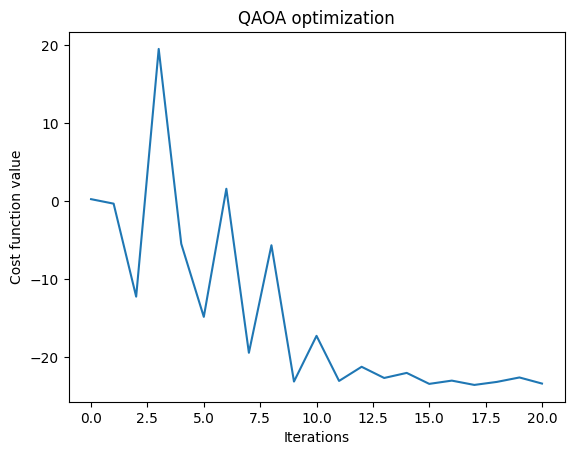

In [39]:
plt.plot([result_dict[i]["fval"] for i in result_dict])
plt.xlabel("Iterations")
plt.ylabel("Cost function value")
plt.title("QAOA optimization")
plt.show()